<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT23/blob/reinisfreibergs_lab2/Lab2/reinisfreibergs_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **The Navier-Stokes equations**
**Reinis Freibergs**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-04-18 11:14:42--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-18 11:14:42 (59.6 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bef019f/releases/pybind11-install.s

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

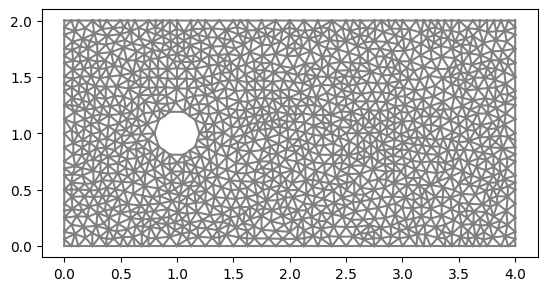

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
# resolution = 8
# resolution = 16
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

The Reynolds number, given by $Re=\frac{UL}{\nu}$, can be changed by changing the viscosity value $\nu$ and keeping the inflow velocity $U$ and the characteristic length of the cylinder $D$ constant.

In [ ]:
# Set viscosity
# nu = 4.0e-4 # Re=1000
nu = 4.0e-3 # Re=100
# nu = 4.0e-2 # Re=10
# nu = 4.0e-1 # Re=1
Re = uin * 2 * rc / nu  
print(Re)

100.0


**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [ ]:
# Define the direction of the force to be computed 
phi_x = 1.0
phi_y = 0.0
mode = 'drag' if phi_x==1 else 'lift' # either drag or lift

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data 
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

mkdir: cannot create directory ‘Re=100_32’: File exists
Time t = 0.03285506167650246


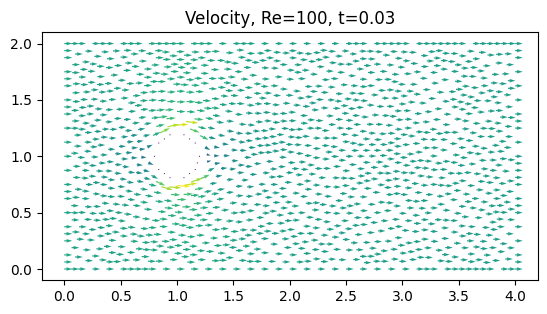

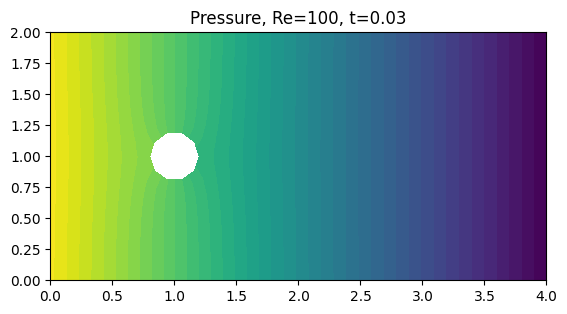

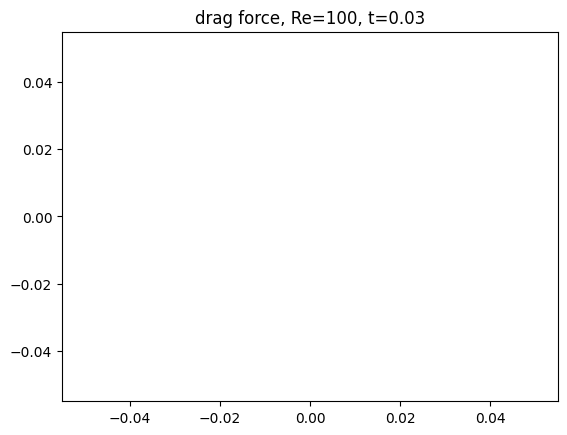

Time t = 3.022665674238231


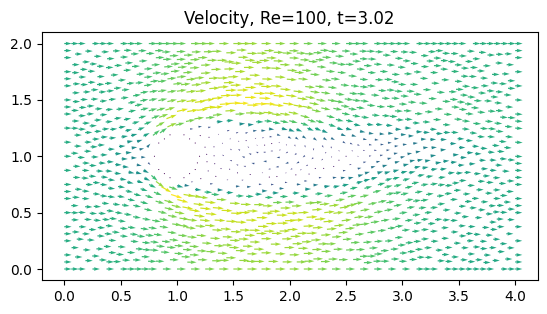

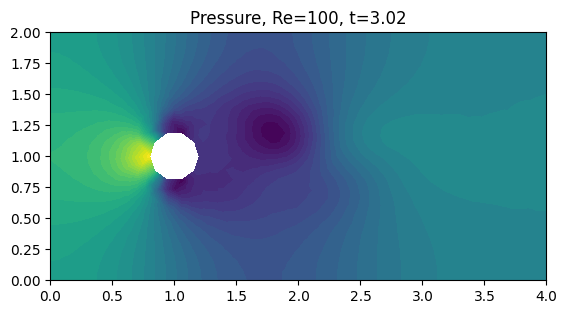

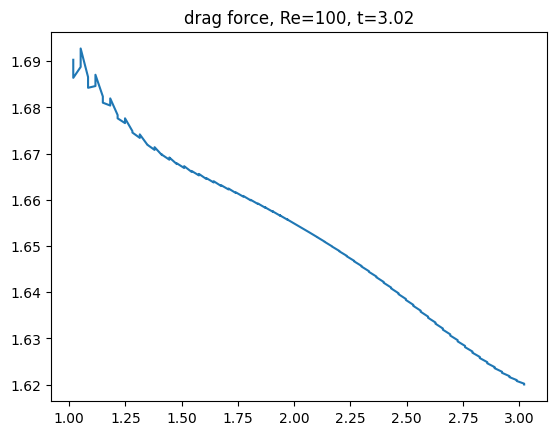

Time t = 6.012476286799972


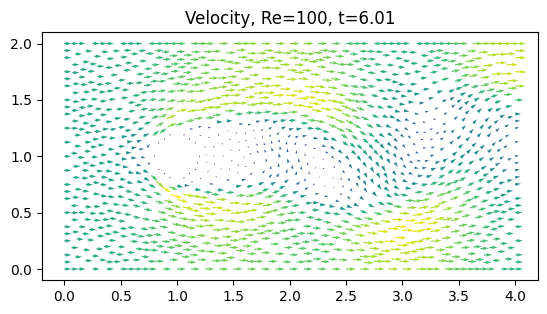

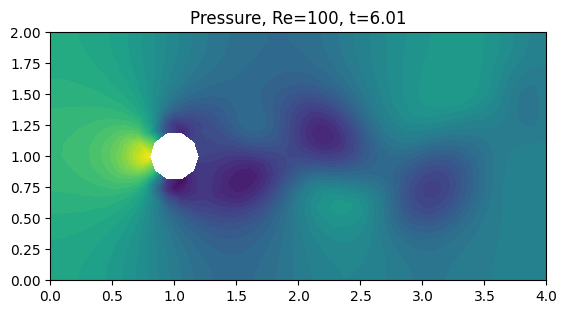

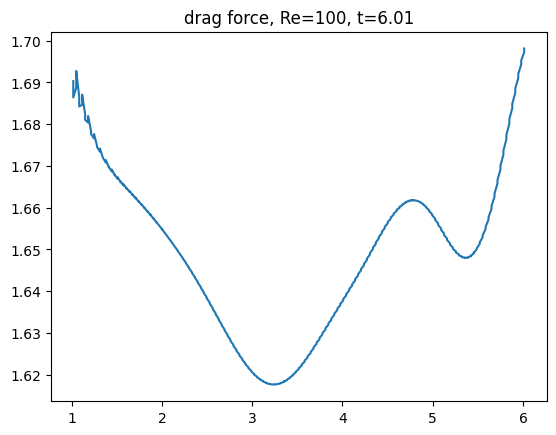

Time t = 9.002286899361685


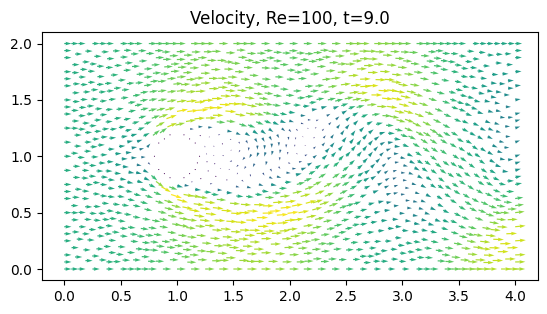

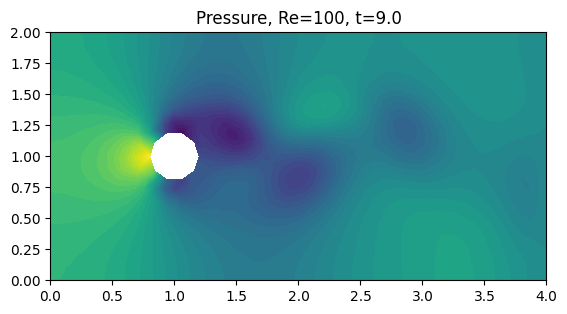

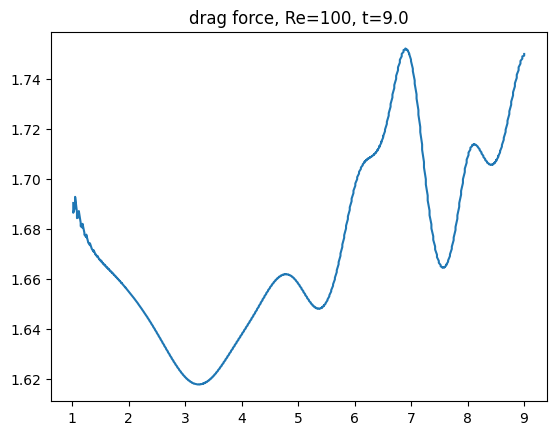

Time t = 12.024952573599847


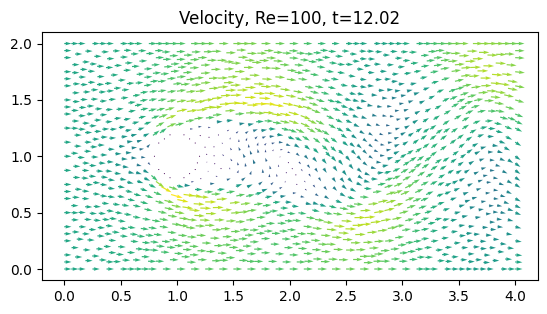

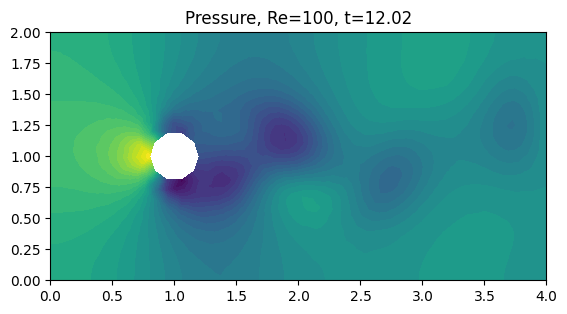

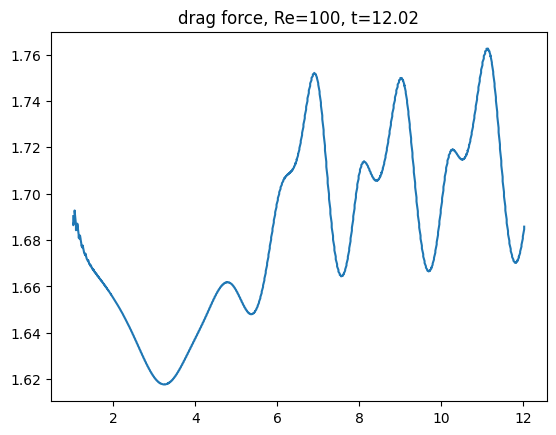

Time t = 15.014763186161508


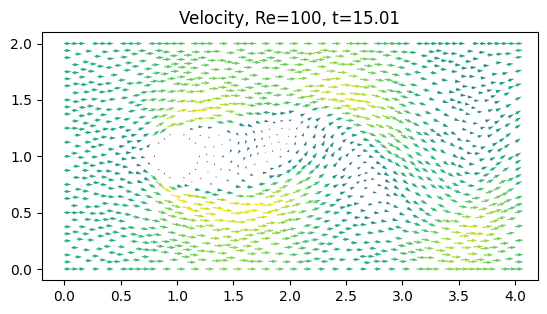

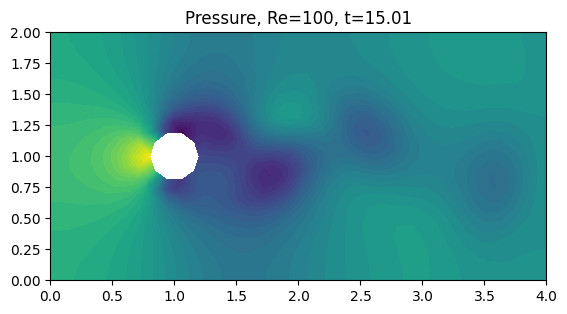

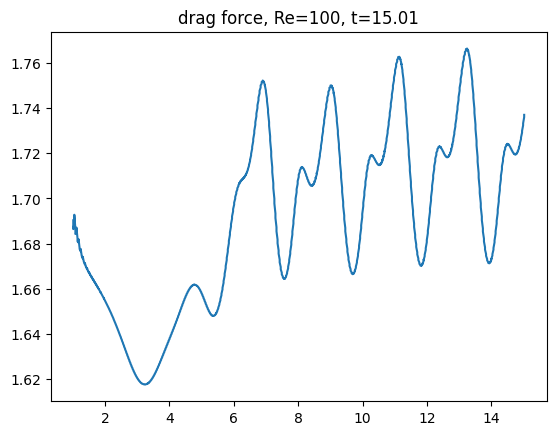

Time t = 18.00457379872328


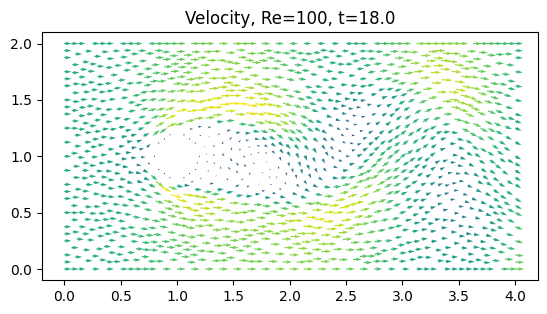

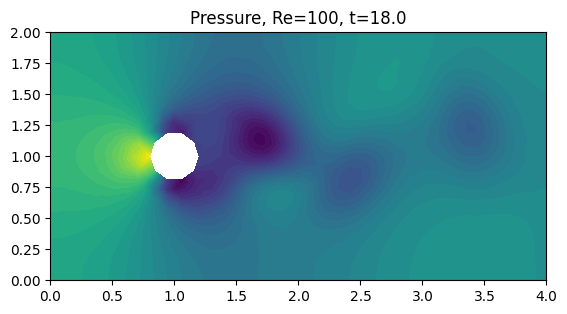

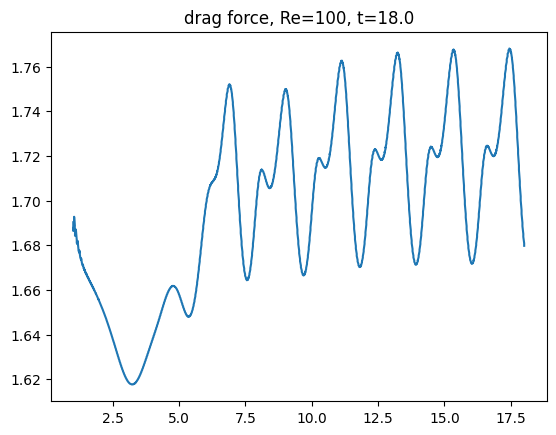

Time t = 21.027239472961604


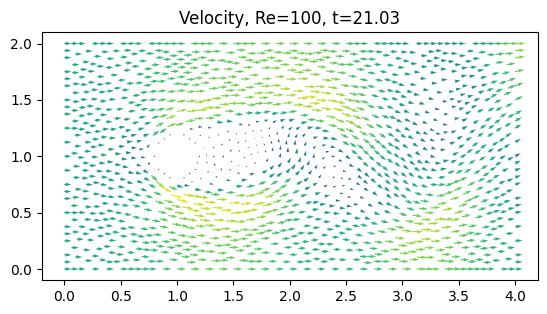

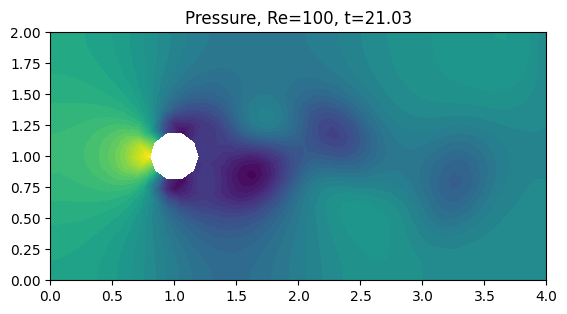

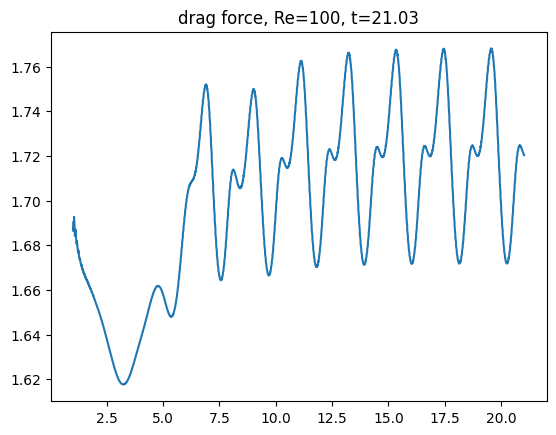

Time t = 24.017050085523426


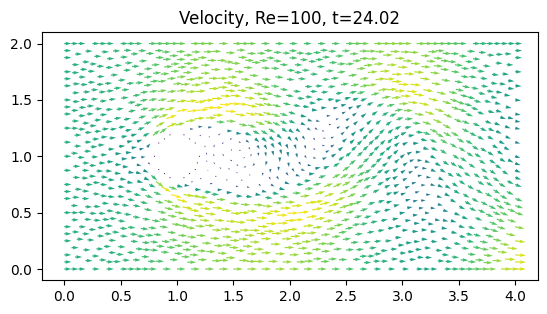

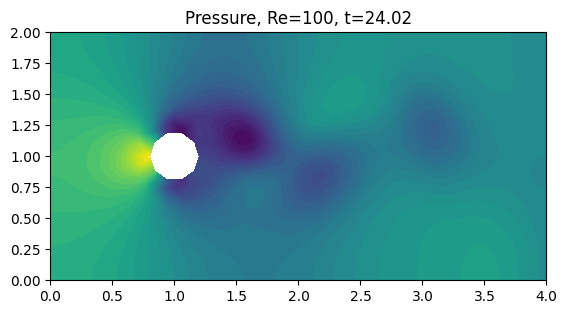

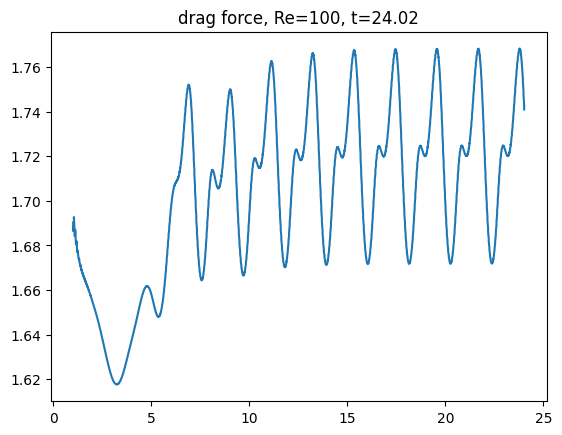

Time t = 27.006860698085248


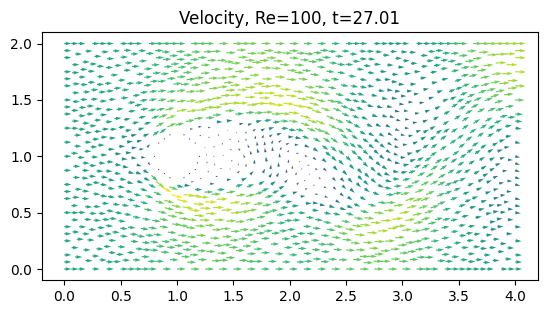

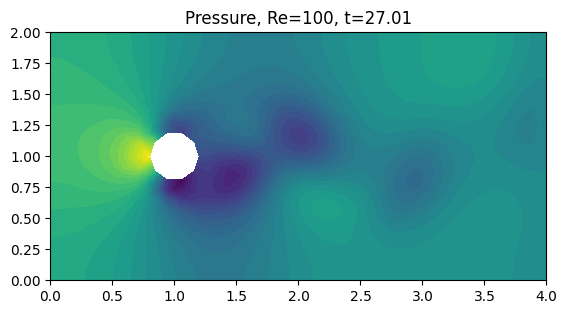

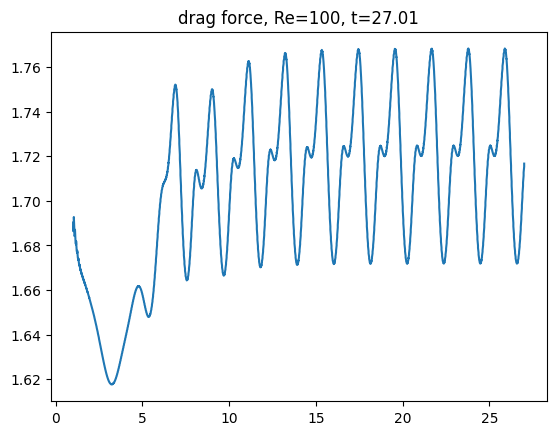

In [ ]:
!rm results-NS/*
!mkdir 'Re={int(Re)}_{resolution}'

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title=f"Velocity, Re={int(Re)}, t={round(t, 2)}")
        plt.savefig(f'./Re={int(Re)}_{resolution}/Velocity, Re={int(Re)}, t={round(t, 2)}, {mode}.png')

        plt.figure()
        plot(p1, title=f"Pressure, Re={int(Re)}, t={round(t, 2)}")
        plt.savefig(f'./Re={int(Re)}_{resolution}/Pressure, Re={int(Re)}, t={round(t, 2)}, {mode}.png')

        plot_time += T/plot_freq
        if round(t, 2)==27.04:
          print(force_array)

        plt.figure()
        plt.title(f"{mode} force, Re={int(Re)}, t={round(t, 2)}")
        plt.plot(time, force_array)
        plt.savefig(f'./Re={int(Re)}_{resolution}/Force, Re={int(Re)}, t={round(t, 2)}, {mode}.png')
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

# !tar -czvf results-NS.tar.gz results-NS
# files.download('results-NS.tar.gz')

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street). Below a further discussion about every experiment is made.

### Reynolds number

Below are presented the images illustrating flow cases with varying Reynolds numbers. With higher Reynolds numbers (100 and 1000) the flow is unsteady and a vortex street is developed. For cases with lower Reynolds numbers the flow was observed to be steady.

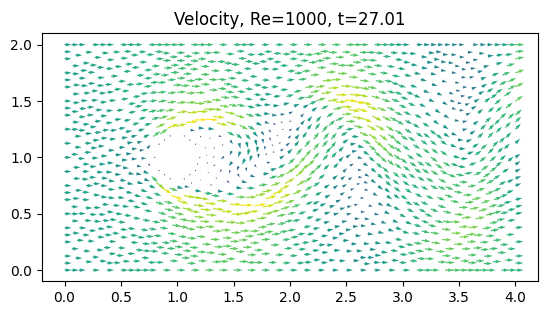

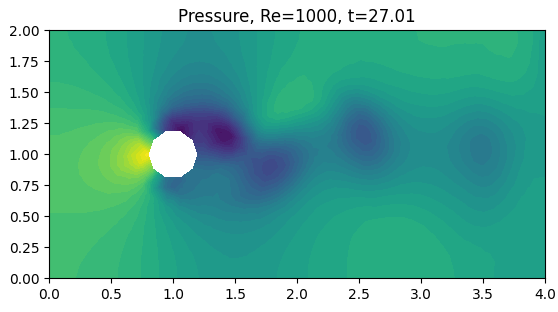

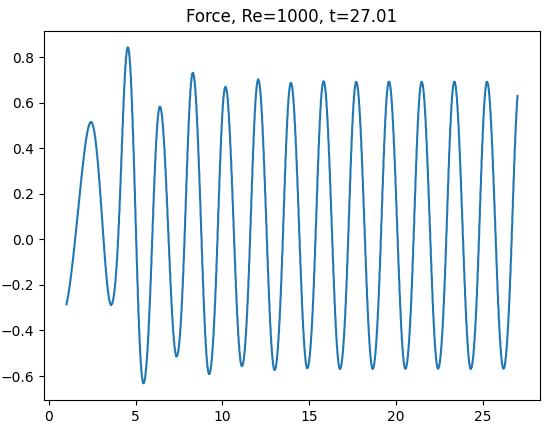

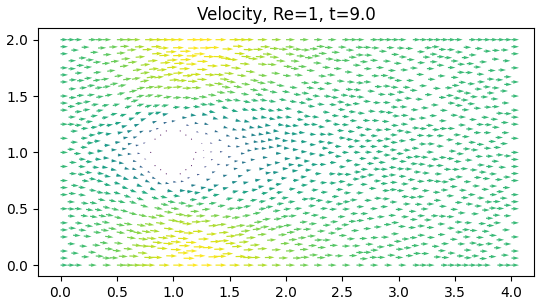

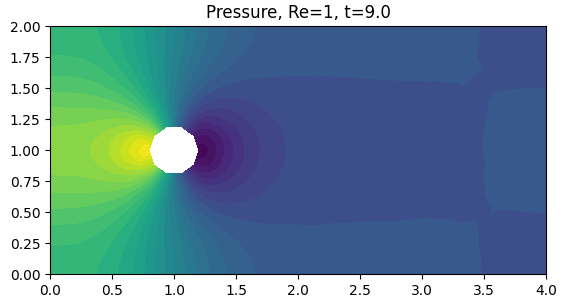

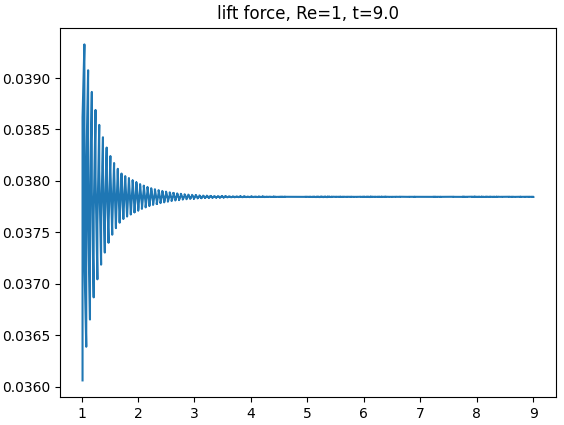

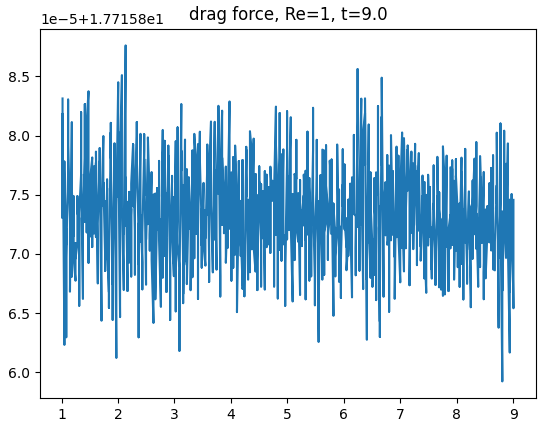

### Drag and lift coefficients

The drag and lift coefficients as well as the Strouhal number were calculated for each flow case with different Reynolds numbers.

The Strouhal number can be calculated by approximating the frequency of vortex shedding from the force plots. 

$$Sh = \frac{fL}{U}$$

where $f$ is the frequency of vortex shedding, $U$ is the flow velocity and $L$ is the length scale. For example considering the $Re=100$ case the vortex shedding frequency determined from the lift force plot is $f=0.47$ thus giving $Sh=\frac{0.47\cdot0.4}{1}=0.188$.

The drag and lift coefficients can be estimated from the force plots.

$$C_d = \frac{2F_d}{\rho U^2 D} \quad C_l = \frac{2F_l}{\rho U^2 D}$$
And since the flow velocity $U=1$, density $\rho=1$ and characteristic length $D=0.4$ values are not changed the expressions can be simplified:

$$C_d = 5F_d \quad C_l = 5F_l$$

For example for $Re=1$ case $Fd=17.715$, thus $C_d=5\cdot F_d=88.58$, $max \ F_l = 0.0377$ thus $C_l = 5 \cdot F_l = 0.19$.
The rest of the coefficients are collected in the table below.


| Re | Cd | Cl | Sh |
| :- | -: | :-: |:-: |
| 1 | 88.58 | 0.19| - |
| 10 | 18.03 | 0.26 | - |
| 100 | 8.60 | 2.15 | 0.19 |
| 1000 | 7.85 | 3.50 | 0.20 |


Data in the table clearly shows that the lift coefficient increases with Reynolds number, which makes sense since vortex shedding introduces larger vertical force components. The drag component decreases with Reynolds number since viscous forces become less important. The Strouhal number for cases with Re=100 and Re=1000 is around 0.2 as expected.

### Mesh resolution

Previous experiments were done with a mesh resolution of 1/32. In this section a comparison is made with coarser meshes with 1/16 and 1/8 resolutions with constant Reynolds number 100. 

The images below illustrate the case of 1/8 resolution.

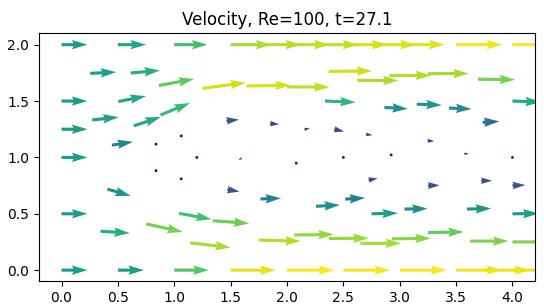

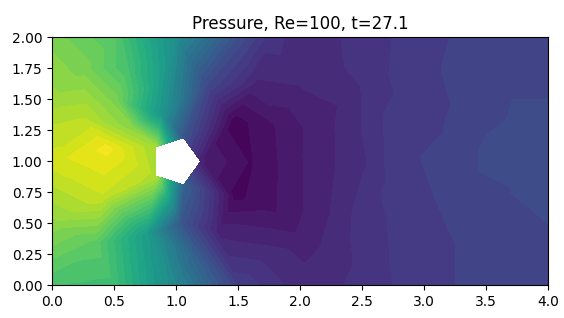

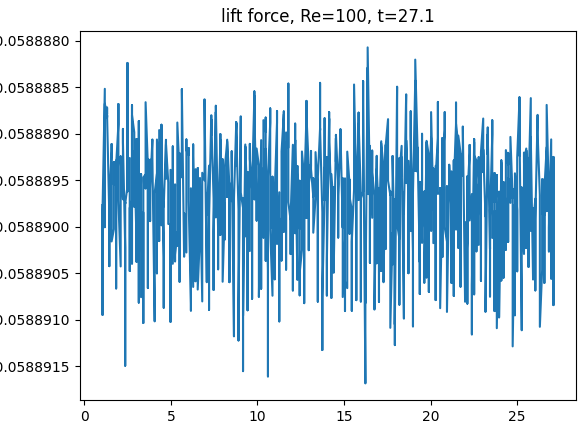

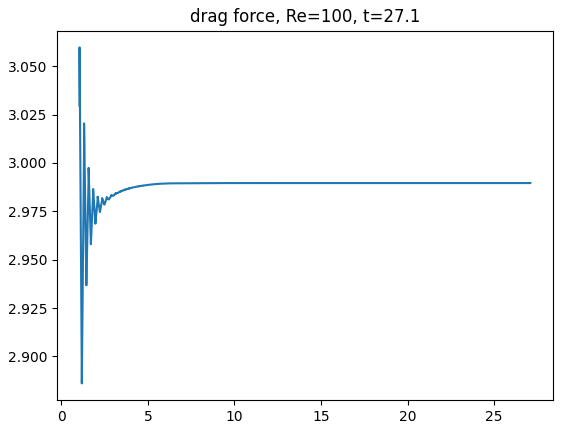

The drag, lift coefficients and Strouhal number are calculated again and can be compared between the resolutions:

| Re | Resolution |Cd | Cl | Sh |
| :- | -: | :-: |:-: |:-: |
| 100 | 1/32 | 8.60| 2.15 | 0.190 |
| 100 | 1/16 | 10.44 | 0.95 |0.164 |
| 100 | 1/8 | 14.89 | 0.29 |- |


As can be seen from the table, reducing the resolution increases the drag and reduces the lift coefficient, while also reducing the Strouhal number (which couldn't even be calculated in the last case due to lack of clear oscillations), which is a similar observation as in the previous experiment with reduced Reynolds numbers. Indicating that a courser mesh is worse at resolving the oscillations and it approaches a steady solution, which also shows in the velocity and pressure plots.

### Paraview visualization

The last point considers visualization of the $Re=100$ case with resolution $h=1/32$. [Velocity](https://drive.google.com/file/d/1X65l7_baB7F7orL8K0HURC-LjsV8uuXV/view?usp=share_link) and [pressure](https://drive.google.com/file/d/1TihEuylB5-Qiu9ifm2Vy52N3NtEVo5ij/view?usp=share_link) animations can be accessed with the hyperlinks.